In [1]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 로그 변환 함수 정의
def log_transform_power(power_data):
    """
    전력 소비량을 자연로그로 변환하는 함수
    
    Parameters:
    - power_data: 전력소비량 데이터 (Series 또는 array)
    
    Returns:
    - 로그 변환된 전력소비량 데이터
    """
    return np.log(power_data + 1)  # +1로 0값 처리

def inverse_log_transform(log_power_data):
    """
    로그 변환된 데이터를 원래 단위로 복원하는 함수
    
    Parameters:
    - log_power_data: 로그 변환된 전력소비량 데이터
    
    Returns:
    - 원래 단위의 전력소비량 데이터
    """
    return np.exp(log_power_data) - 1

# 한글 폰트 설정
import matplotlib.font_manager as fm
import os

# 윈도우 환경에서 한글 폰트 설정
font_paths = [
    'C:/Windows/Fonts/malgun.ttf',
    'C:/Windows/Fonts/malgunbd.ttf',
    'C:/Windows/Fonts/malgunsl.ttf'
]

font_found = False
for font_path in font_paths:
    if os.path.exists(font_path):
        font_name = fm.FontProperties(fname=font_path).get_name()
        plt.rcParams['font.family'] = font_name
        font_found = True
        print(f"✅ 한글 폰트 설정 완료: {font_name}")
        break

if not font_found:
    plt.rcParams['font.family'] = 'DejaVu Sans'
    print("⚠️ 한글 폰트를 찾을 수 없어 기본 폰트를 사용합니다.")

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (15, 8)

# 시각화 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

print("🔧 환경 설정 완료")


✅ 한글 폰트 설정 완료: Malgun Gothic
🔧 환경 설정 완료


In [2]:
# 데이터 로드
train_df = pd.read_csv('data/train.csv')
building_info = pd.read_csv('data/building_info.csv')

# 일시 컬럼을 datetime으로 변환
train_df['일시'] = pd.to_datetime(train_df['일시'], format='%Y%m%d %H')

print("📊 데이터 로드 완료")
print(f"Train 데이터: {train_df.shape}")
print(f"Building 정보: {building_info.shape}")
print(f"기간: {train_df['일시'].min()} ~ {train_df['일시'].max()}")

# 건물 유형 확인
print("\n🏢 건물 유형별 개수:")
building_types = building_info['건물유형'].value_counts()
for building_type, count in building_types.items():
    print(f"   {building_type}: {count}개")


📊 데이터 로드 완료
Train 데이터: (204000, 10)
Building 정보: (100, 7)
기간: 2024-06-01 00:00:00 ~ 2024-08-24 23:00:00

🏢 건물 유형별 개수:
   백화점: 16개
   호텔: 10개
   상용: 10개
   학교: 10개
   건물기타: 10개
   병원: 9개
   아파트: 9개
   연구소: 9개
   IDC(전화국): 9개
   공공: 8개


In [3]:
train_df

,num_date_time,건물번호,일시,기온(°C),강수량(mm),풍속(m/s),습도(%),일조(hr),일사(MJ/m2),전력소비량(kWh)
0,1_20240601 00,1,2024-06-01 00:00:00,18.3,0.0,2.6,82.0,0.0,0.00,5794.80
1,1_20240601 01,1,2024-06-01 01:00:00,18.3,0.0,2.7,82.0,0.0,0.00,5591.85
2,1_20240601 02,1,2024-06-01 02:00:00,18.1,0.0,2.6,80.0,0.0,0.00,5338.17
3,1_20240601 03,1,2024-06-01 03:00:00,18.0,0.0,2.6,81.0,0.0,0.00,4554.42
4,1_20240601 04,1,2024-06-01 04:00:00,17.8,0.0,1.3,81.0,0.0,0.00,3602.25
...,...,...,...,...,...,...,...,...,...,...
203995,100_20240824 19,100,2024-08-24 19:00:00,29.1,0.0,4.4,76.0,0.4,0.18,3276.00
203996,100_20240824 20,100,2024-08-24 20:00:00,28.6,0.0,3.7,74.0,0.0,0.00,3197.52
203997,100_20240824 21,100,2024-08-24 21:00:00,28.3,0.0,2.9,74.0,0.0,0.00,3006.60
203998,100_20240824 22,100,2024-08-24 22:00:00,28.0,0.0,1.7,76.0,0.0,0.00,2649.72


In [4]:
def visualize_building(building_number):
    """
    특정 건물의 전력 소비량을 로그 변환하여 시각화하는 함수
    
    Parameters:
    - building_number: 건물 번호 (1-100)
    """
    
    # 건물 데이터 필터링
    building_data = train_df[train_df['건물번호'] == building_number].copy()
    
    if len(building_data) == 0:
        print(f"❌ {building_number}번 건물 데이터가 없습니다.")
        return
    
    # 건물 정보 가져오기
    building_type = building_info[building_info['건물번호'] == building_number]['건물유형'].iloc[0]
    power_data = building_data['전력소비량(kWh)']
    
    # 로그 변환 적용
    log_power_data = log_transform_power(power_data)
    building_data['로그전력소비량'] = log_power_data
    
    # 기본 통계 정보 (로그 변환된 데이터)
    print(f"🏢 {building_number}번 건물 ({building_type}) 전력 소비량 분석 (로그 변환)")
    print(f"   데이터 개수: {len(log_power_data):,}개")
    print(f"   평균: {log_power_data.mean():.3f} log(kWh)")
    print(f"   중앙값: {log_power_data.median():.3f} log(kWh)")
    print(f"   최댓값: {log_power_data.max():.3f} log(kWh)")
    print(f"   최솟값: {log_power_data.min():.3f} log(kWh)")
    print(f"   표준편차: {log_power_data.std():.3f} log(kWh)")
    
    # 원본 데이터 통계 참고용 출력
    print(f"\n📊 원본 데이터 참고 (kWh 단위):")
    print(f"   평균: {power_data.mean():.2f}, 중앙값: {power_data.median():.2f}")
    print(f"   최댓값: {power_data.max():.2f}, 최솟값: {power_data.min():.2f}")
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'{building_number}번 건물 ({building_type}) 전력 소비량 분석 (로그 변환)', fontsize=16, fontweight='bold')
    
    # 1. 시계열 그래프
    ax1 = axes[0, 0]
    ax1.plot(building_data['일시'], log_power_data, linewidth=0.8, color='steelblue', alpha=0.7)
    ax1.set_title('시계열 전력 소비량 (로그 변환)')
    ax1.set_xlabel('날짜')
    ax1.set_ylabel('전력 소비량 log(kWh)')
    ax1.grid(True, alpha=0.3)
    
    # 2. 일별 평균 패턴
    ax2 = axes[0, 1]
    building_data['일'] = building_data['일시'].dt.day
    building_data['시간'] = building_data['일시'].dt.hour
    daily_avg = building_data.groupby('일')['로그전력소비량'].mean()
    ax2.plot(daily_avg.index, daily_avg.values, marker='o', linewidth=2, markersize=4, color='green')
    ax2.set_title('일별 평균 전력 소비량 (로그 변환)')
    ax2.set_xlabel('일')
    ax2.set_ylabel('평균 전력 소비량 log(kWh)')
    ax2.grid(True, alpha=0.3)
    
    # 3. 시간대별 평균 패턴
    ax3 = axes[1, 0]
    hourly_avg = building_data.groupby('시간')['로그전력소비량'].mean()
    bars = ax3.bar(hourly_avg.index, hourly_avg.values, color='orange', alpha=0.7)
    ax3.set_title('시간대별 평균 전력 소비량 (로그 변환)')
    ax3.set_xlabel('시간')
    ax3.set_ylabel('평균 전력 소비량 log(kWh)')
    ax3.set_xticks(range(0, 24, 2))
    ax3.grid(True, alpha=0.3)
    
    # 4. 히스토그램
    ax4 = axes[1, 1]
    ax4.hist(log_power_data, bins=30, color='purple', alpha=0.7, edgecolor='black')
    ax4.axvline(log_power_data.mean(), color='red', linestyle='--', linewidth=2, label=f'평균: {log_power_data.mean():.3f}')
    ax4.axvline(log_power_data.median(), color='green', linestyle='--', linewidth=2, label=f'중앙값: {log_power_data.median():.3f}')
    ax4.set_title('전력 소비량 분포 (로그 변환)')
    ax4.set_xlabel('전력 소비량 log(kWh)')
    ax4.set_ylabel('빈도')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 요일별 패턴 분석
    building_data['요일'] = building_data['일시'].dt.day_name()
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_korean = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    weekday_avg = building_data.groupby('요일')['로그전력소비량'].mean().reindex(weekday_order)
    
    bars = ax.bar(weekday_korean, weekday_avg.values, color='lightcoral', alpha=0.8)
    ax.set_title(f'{building_number}번 건물 요일별 평균 전력 소비량 (로그 변환)')
    ax.set_ylabel('평균 전력 소비량 log(kWh)')
    ax.grid(True, alpha=0.3)
    
    # 막대 위에 값 표시
    for bar, value in zip(bars, weekday_avg.values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
                f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("✅ 단일 건물 시각화 함수 생성 완료!")
print("   사용법: visualize_building(건물번호)")
print("   예시: visualize_building(1)")


✅ 단일 건물 시각화 함수 생성 완료!
   사용법: visualize_building(건물번호)
   예시: visualize_building(1)


In [5]:
def visualize_building_type(building_type):
    """
    동일 유형 건물들의 전력 소비량을 로그 변환하여 시각화하는 함수
    
    Parameters:
    - building_type: 건물 유형 (예: '호텔', '학교', '병원' 등)
    """
    
    # 해당 유형의 건물들 찾기
    buildings_of_type = building_info[building_info['건물유형'] == building_type]
    
    if len(buildings_of_type) == 0:
        print(f"❌ '{building_type}' 유형의 건물이 없습니다.")
        print("사용 가능한 건물 유형:", list(building_info['건물유형'].unique()))
        return
    
    building_numbers = buildings_of_type['건물번호'].tolist()
    
    print(f"🏢 {building_type} 유형 건물 분석 (로그 변환)")
    print(f"   분석 대상: {len(building_numbers)}개 건물")
    print(f"   건물 번호: {building_numbers}")
    
    # 각 건물의 데이터 수집
    building_data_list = []
    building_stats = []
    
    for building_num in building_numbers:
        data = train_df[train_df['건물번호'] == building_num].copy()
        if len(data) > 0:
            # 로그 변환 적용
            power_data = data['전력소비량(kWh)']
            log_power_data = log_transform_power(power_data)
            data['로그전력소비량'] = log_power_data
            
            building_data_list.append(data)
            building_stats.append({
                '건물번호': building_num,
                '평균': log_power_data.mean(),
                '중앙값': log_power_data.median(),
                '최댓값': log_power_data.max(),
                '최솟값': log_power_data.min(),
                '표준편차': log_power_data.std()
            })
    
    stats_df = pd.DataFrame(building_stats)
    
    # 통계 정보 출력 (로그 변환된 데이터)
    print(f"\n📊 {building_type} 유형 건물 통계 (로그 변환):")
    print(f"   평균 전력 소비량: {stats_df['평균'].mean():.3f} log(kWh)")
    print(f"   최고 평균 소비량: {stats_df['평균'].max():.3f} log(kWh) (건물 {stats_df.loc[stats_df['평균'].idxmax(), '건물번호']}번)")
    print(f"   최저 평균 소비량: {stats_df['평균'].min():.3f} log(kWh) (건물 {stats_df.loc[stats_df['평균'].idxmin(), '건물번호']}번)")
    
    # 원본 데이터 통계 참고용 출력
    original_stats = []
    for data in building_data_list:
        original_power = data['전력소비량(kWh)']
        original_stats.append(original_power.mean())
    
    print(f"\n📊 원본 데이터 참고 (kWh 단위):")
    print(f"   평균 전력 소비량: {np.mean(original_stats):.2f} kWh")
    print(f"   최고 평균 소비량: {np.max(original_stats):.2f} kWh")
    print(f"   최저 평균 소비량: {np.min(original_stats):.2f} kWh")
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle(f'{building_type} 유형 건물들 전력 소비량 분석 (로그 변환)', fontsize=16, fontweight='bold')
    
    # 1. 건물별 평균 전력 소비량 비교
    ax1 = axes[0, 0]
    colors = plt.cm.Set3(np.linspace(0, 1, len(building_numbers)))
    bars = ax1.bar(range(len(building_numbers)), stats_df['평균'].values, color=colors, alpha=0.8)
    ax1.set_title('건물별 평균 전력 소비량 (로그 변환)')
    ax1.set_xlabel('건물')
    ax1.set_ylabel('평균 전력 소비량 log(kWh)')
    ax1.set_xticks(range(len(building_numbers)))
    ax1.set_xticklabels([f'{num}번' for num in building_numbers], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # 막대 위에 값 표시
    for bar, value in zip(bars, stats_df['평균'].values):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + value*0.01, 
                f'{value:.2f}', ha='center', va='bottom', fontsize=10)
    
    # 2. 시간대별 평균 패턴 비교
    ax2 = axes[0, 1]
    for i, data in enumerate(building_data_list):
        data['시간'] = data['일시'].dt.hour
        hourly_avg = data.groupby('시간')['로그전력소비량'].mean()
        ax2.plot(hourly_avg.index, hourly_avg.values, 
                marker='o', linewidth=2, markersize=3, alpha=0.7, 
                label=f'{building_numbers[i]}번', color=colors[i])
    
    ax2.set_title('시간대별 평균 전력 소비량 패턴 (로그 변환)')
    ax2.set_xlabel('시간')
    ax2.set_ylabel('평균 전력 소비량 log(kWh)')
    ax2.set_xticks(range(0, 24, 2))
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # 3. 전력 소비량 분포 비교 (박스플롯)
    ax3 = axes[1, 0]
    box_data = []
    box_labels = []
    for i, data in enumerate(building_data_list):
        box_data.append(data['로그전력소비량'].values)
        box_labels.append(f'{building_numbers[i]}번')
    
    bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax3.set_title('건물별 전력 소비량 분포 (로그 변환)')
    ax3.set_xlabel('건물')
    ax3.set_ylabel('전력 소비량 log(kWh)')
    ax3.grid(True, alpha=0.3)
    
    # 4. 통계 지표 히트맵
    ax4 = axes[1, 1]
    heatmap_data = stats_df.set_index('건물번호')[['평균', '중앙값', '최댓값', '최솟값', '표준편차']].T
    im = ax4.imshow(heatmap_data.values, cmap='YlOrRd', aspect='auto')
    
    # 히트맵 설정
    ax4.set_xticks(range(len(building_numbers)))
    ax4.set_xticklabels([f'{num}번' for num in building_numbers])
    ax4.set_yticks(range(len(heatmap_data.index)))
    ax4.set_yticklabels(heatmap_data.index)
    ax4.set_title('건물별 통계 지표 히트맵 (로그 변환)')
    
    # 값 표시
    for i in range(len(heatmap_data.index)):
        for j in range(len(building_numbers)):
            text = ax4.text(j, i, f'{heatmap_data.iloc[i, j]:.2f}', 
                          ha='center', va='center', fontsize=9, fontweight='bold')
    
    # 컬러바 추가
    cbar = plt.colorbar(im, ax=ax4)
    cbar.set_label('전력 소비량 log(kWh)')
    
    plt.tight_layout()
    plt.show()
    
    # 요일별 패턴 비교
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    weekday_korean = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
    
    x = np.arange(len(weekday_korean))
    width = 0.8 / len(building_numbers)
    
    for i, data in enumerate(building_data_list):
        data['요일'] = data['일시'].dt.day_name()
        weekday_avg = data.groupby('요일')['로그전력소비량'].mean().reindex(weekday_order)
        
        bars = ax.bar(x + i * width, weekday_avg.values, width, 
                     label=f'{building_numbers[i]}번', color=colors[i], alpha=0.8)
    
    ax.set_title(f'{building_type} 유형 건물들의 요일별 평균 전력 소비량 (로그 변환)')
    ax.set_xlabel('요일')
    ax.set_ylabel('평균 전력 소비량 log(kWh)')
    ax.set_xticks(x + width * (len(building_numbers) - 1) / 2)
    ax.set_xticklabels(weekday_korean)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 상세 통계 테이블 출력
    print(f"\n📋 {building_type} 유형 건물별 상세 통계 (로그 변환):")
    print(stats_df.round(3).to_string(index=False))

print("✅ 동일 유형 건물 전체 시각화 함수 생성 완료!")
print("   사용법: visualize_building_type('건물유형')")
print("   예시: visualize_building_type('호텔')")
print("   가능한 건물 유형:", list(building_info['건물유형'].unique()))


✅ 동일 유형 건물 전체 시각화 함수 생성 완료!
   사용법: visualize_building_type('건물유형')
   예시: visualize_building_type('호텔')
   가능한 건물 유형: ['호텔', '상용', '병원', '학교', '건물기타', '아파트', '연구소', '백화점', 'IDC(전화국)', '공공']


In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import seaborn as sns

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

📊 사용 예시 1: 5번 건물 분석
🏢 2번 건물 (상용) 전력 소비량 분석 (로그 변환)
   데이터 개수: 2,040개
   평균: 7.385 log(kWh)
   중앙값: 7.442 log(kWh)
   최댓값: 8.052 log(kWh)
   최솟값: 6.675 log(kWh)
   표준편차: 0.286 log(kWh)

📊 원본 데이터 참고 (kWh 단위):
   평균: 1676.24, 중앙값: 1705.65
   최댓값: 3139.08, 최솟값: 791.64


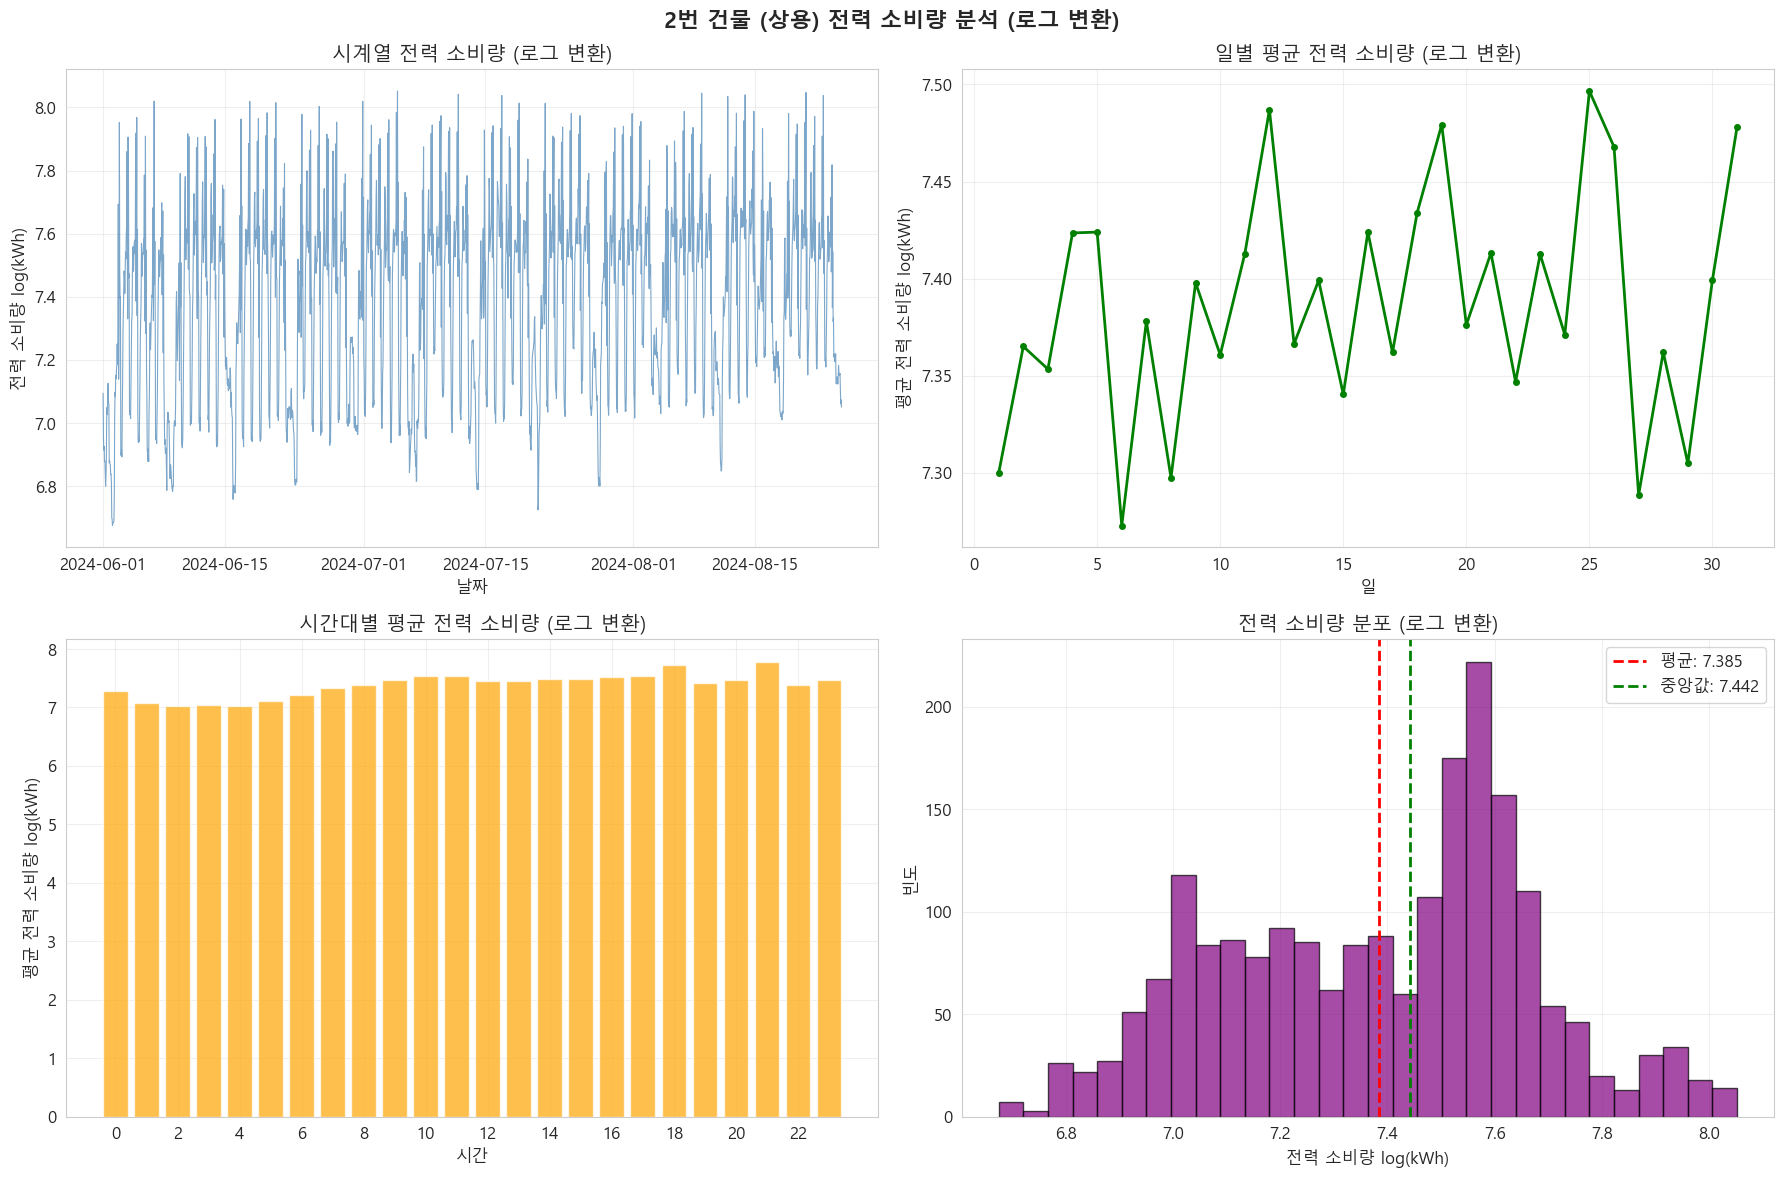

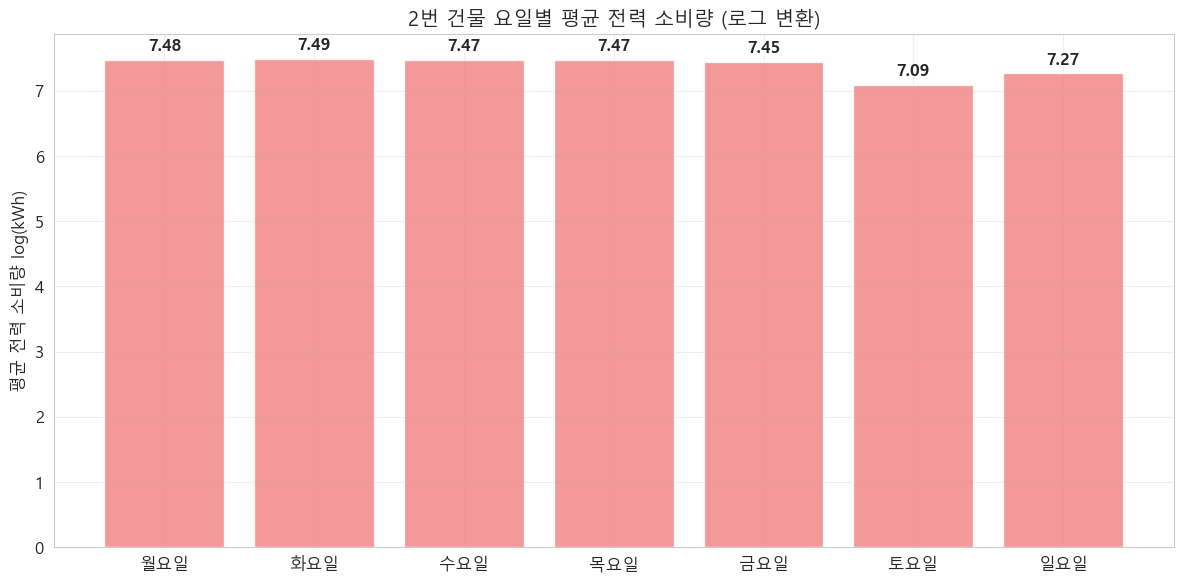

In [10]:
# 🎯 사용 예시 1: 특정 건물 분석 (5번 건물)
print("=" * 60)
print("📊 사용 예시 1: 5번 건물 분석")
print("=" * 60)
visualize_building(2)


📊 사용 예시 2: 호텔 유형 건물들 분석
🏢 병원 유형 건물 분석 (로그 변환)
   분석 대상: 9개 건물
   건물 번호: [3, 17, 21, 39, 42, 44, 48, 75, 90]

📊 병원 유형 건물 통계 (로그 변환):
   평균 전력 소비량: 8.079 log(kWh)
   최고 평균 소비량: 9.735 log(kWh) (건물 3번)
   최저 평균 소비량: 7.446 log(kWh) (건물 44번)

📊 원본 데이터 참고 (kWh 단위):
   평균 전력 소비량: 4454.06 kWh
   최고 평균 소비량: 17449.53 kWh
   최저 평균 소비량: 1784.69 kWh


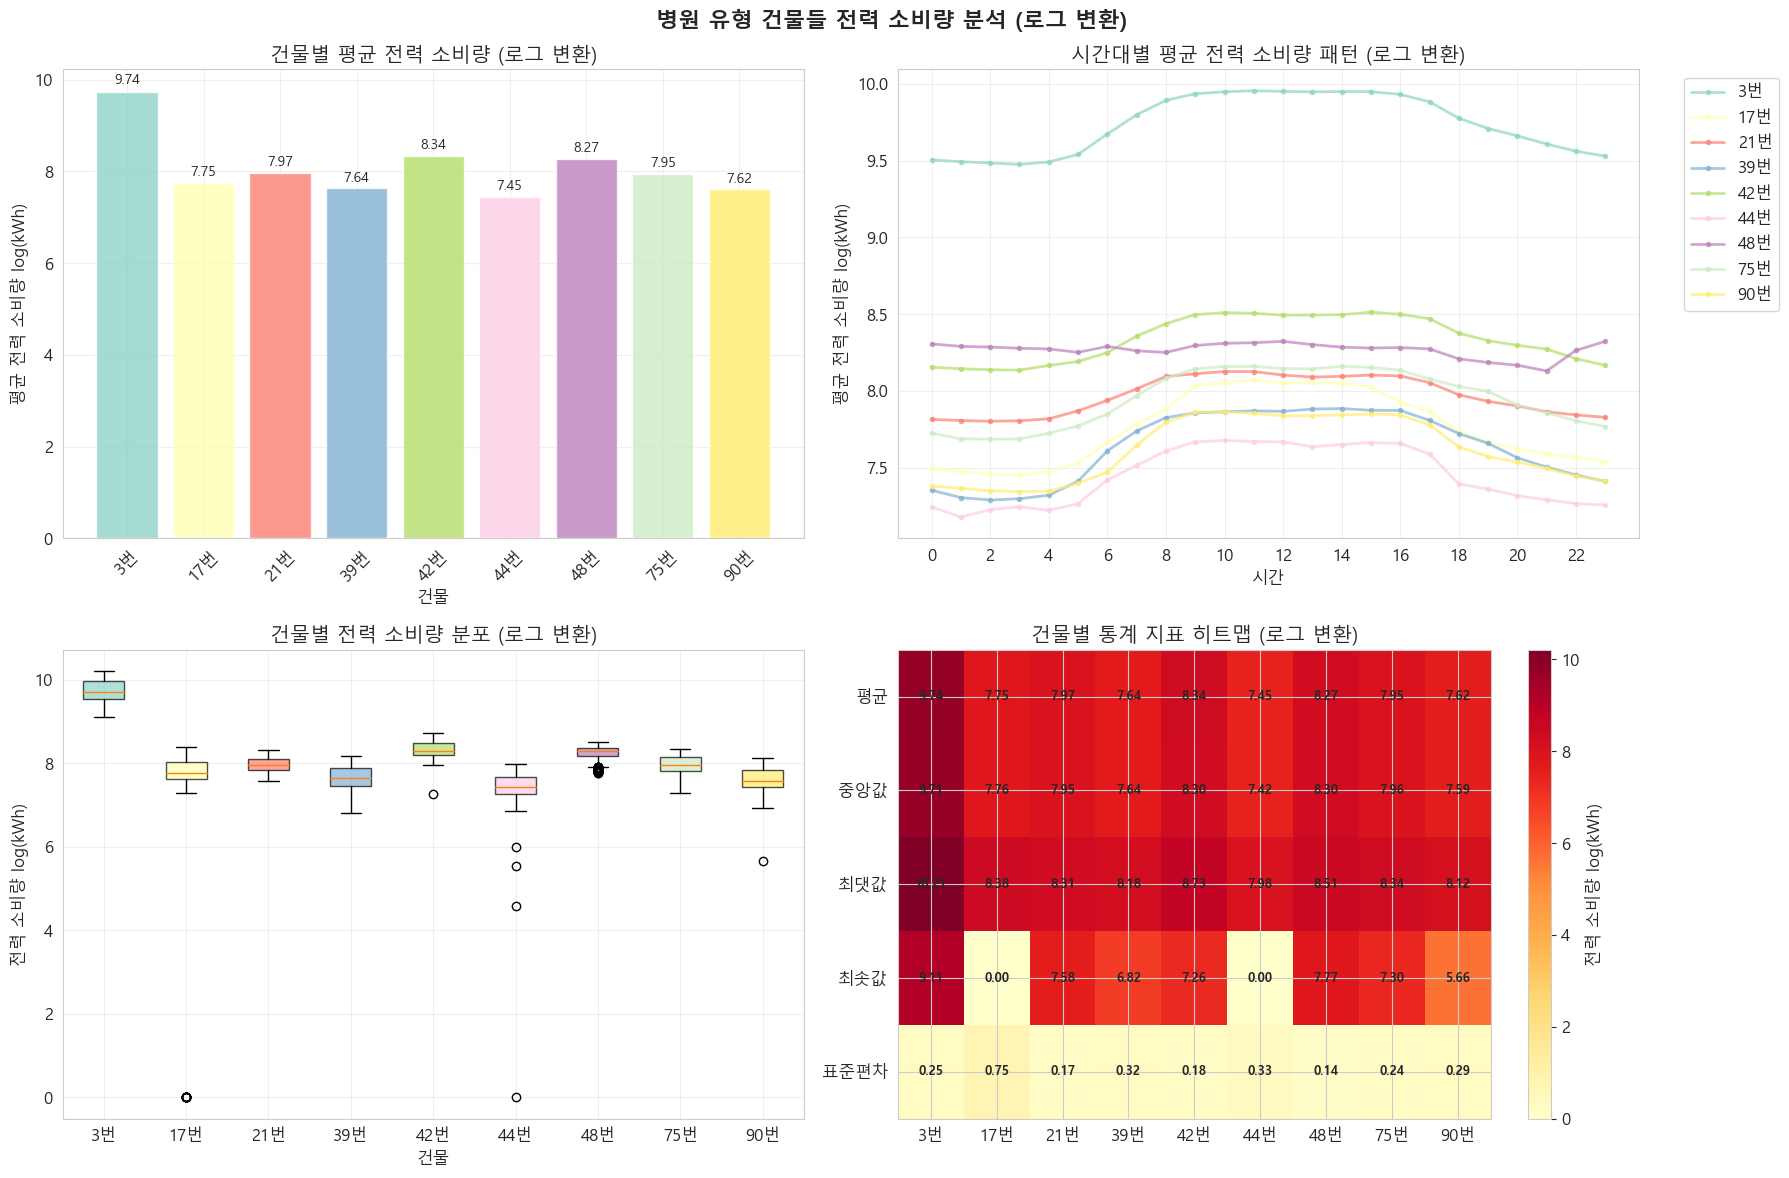

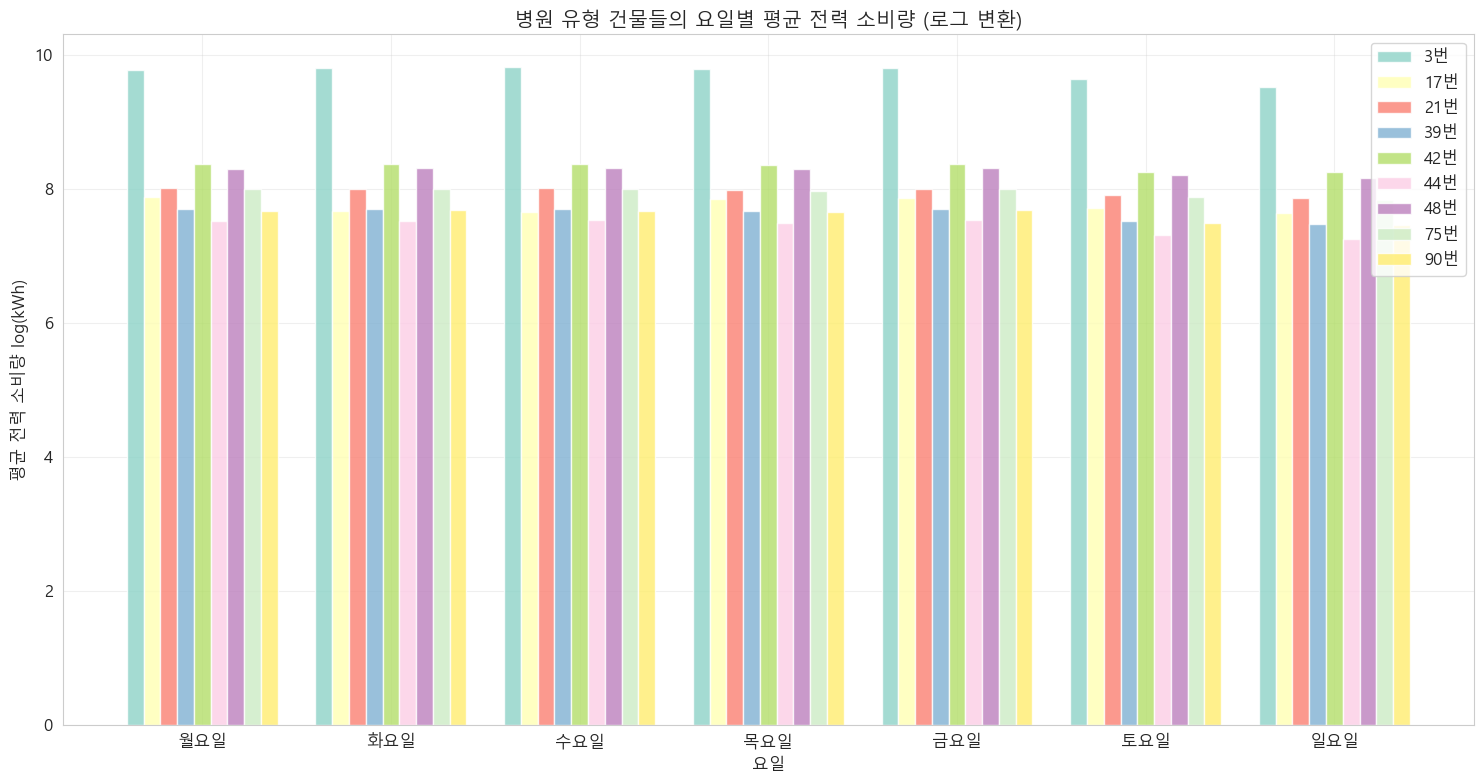


📋 병원 유형 건물별 상세 통계 (로그 변환):
 건물번호    평균   중앙값    최댓값   최솟값  표준편차
    3 9.735 9.714 10.209 9.112 0.253
   17 7.753 7.762  8.383 0.000 0.755
   21 7.967 7.950  8.310 7.583 0.170
   39 7.635 7.644  8.181 6.816 0.318
   42 8.338 8.299  8.732 7.262 0.185
   44 7.446 7.423  7.982 0.000 0.329
   48 8.268 8.296  8.505 7.765 0.137
   75 7.951 7.958  8.344 7.300 0.238
   90 7.616 7.589  8.116 5.659 0.288


In [12]:
# 🎯 사용 예시 2: 호텔 유형 건물들 분석
print("=" * 60)
print("📊 사용 예시 2: 호텔 유형 건물들 분석")
print("=" * 60)
visualize_building_type('병원')
